In [ ]:
"""
titanic_ml.ipynb. Modfied excercise from
    Hands-On Quantum Machine Learning With Python
    Volume 1: Get Started by Dr. Frank Zickert
    Copyright © 2021 Dr. Frank Zickert, pyqml.com
Chapter 2 Binary Classification
I added Accuracy and Matthews Correlation Coefficient metrics,
Also added scatter_matrix plot and consistency checks on the metrics.
Omitted random and predict_death classifiers.
"""
None

In [72]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import random
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, precision_score, accuracy_score
from sklearn.metrics import confusion_matrix, matthews_corrcoef

In [56]:
# These files can be downloaded from a Kaggle competition.
train = pd.read_csv('./titanic/train.csv')
test = pd.read_csv('./titanic/test.csv')

In [57]:
train.info()
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass  

In [58]:
train = train.dropna(subset=["Embarked"])
train = train.drop("Cabin", axis=1)
mean = train["Age"].mean()
train["Age"] = train["Age"].fillna(mean)
train = train.drop("PassengerId", axis=1)
train = train.drop("Name", axis=1)
train = train.drop("Ticket", axis=1)
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  889 non-null    int64  
 1   Pclass    889 non-null    int64  
 2   Sex       889 non-null    object 
 3   Age       889 non-null    float64
 4   SibSp     889 non-null    int64  
 5   Parch     889 non-null    int64  
 6   Fare      889 non-null    float64
 7   Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 62.5+ KB


In [64]:
le = LabelEncoder()
for col in ['Sex', 'Embarked']:
    le.fit(train[col])
    train[col] = le.transform(train[col])
train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,1,22.0,1,0,7.2500,2
1,1,1,0,38.0,1,0,71.2833,0
2,1,3,0,26.0,0,0,7.9250,2
3,1,1,0,35.0,1,0,53.1000,2
4,0,3,1,35.0,0,0,8.0500,2


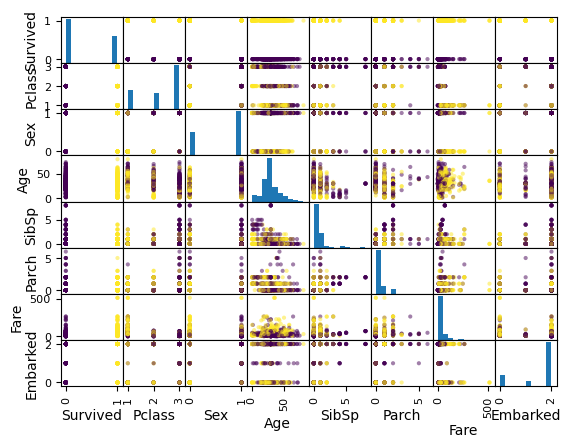

In [71]:
# My addition: exploratory plots
df = train[train.columns[1:8]]
survived = train[train.columns[0]]
pd.plotting.scatter_matrix(train, c=survived, alpha=0.5, diagonal='hist', range_padding=.2)
"""
Since most people did not survive (yellow), random choice should not be 50-50.
Could break study down by class * sex * embarked = 3 * 2 * 3 = 18 cases.
Could break down further by SibSp * Parch * Fare = 2 * 2 * 2 = another factor of 8.
3rd class patterns: males and embark 3 died.
sex patterns: most crosses show males died.
age cross fare shows low fare died.
SibSp and Parch show complex non-linear clusters, so worth separate analyses.
"""
None

In [24]:
scaler = MinMaxScaler()
scaler.fit(train)
train = scaler.transform(train)

In [25]:
input_data = train[:, 1:8]
labels = train[:, 0]
train_input, test_input, train_labels, test_labels = train_test_split(
    input_data, labels, test_size = 0.2)
print(f'train/test shapes {train_input.shape}, {test_input.shape}, {train_labels.shape}, {test_labels.shape}')

train/test shapes (711, 7), (178, 7), (711,), (178,)


In [26]:
with open('./titanic/train.npy', 'wb') as f:
    np.save(f, train_input)
    np.save(f, train_labels)
with open('./titanic/test.npy', 'wb') as f:
    np.save(f, test_input)
    np.save(f, test_labels)

In [38]:
random.seed(a=None, version=2)
def random_classify(passenger):
    return random.randint(0, 1)

def specificity(matrix):
    """Specificity := TN / All Actual Negatives.
    Confusion matrix is [[TN, FP], [FN, TP]] ."""
    den = matrix[0][0] + matrix[0][1]
    return matrix[0][0] / den if 0 < den else 0

def npv(matrix):
    """Negative Predictive Value := TN / All Predicted Negatives
    Confusion matrix is [[TN, FP], [FN, TP]] ."""
    den = matrix[0][0] + matrix[1][0]
    return matrix[0][0] / den if 0 < den else 0

def run(f_classify, x):
    return list(map(f_classify, x))

def classifier_report(name, run, classify, inputs, labels):
    cr_predictions = run(classify, inputs)
    cr_cm = confusion_matrix(labels, cr_predictions)
    cr_prec = precision_score(labels, cr_predictions)
    cr_rec = recall_score(labels, cr_predictions)
    cr_spec = specificity(cr_cm)
    cr_npv = npv(cr_cm)
    cr_info = 0.25*(cr_prec + cr_rec + cr_spec + cr_npv)
    cr_acc = accuracy_score(labels, cr_predictions)
    cr_mcc = matthews_corrcoef(labels, cr_predictions)
    print(f'{name}: prec {cr_prec:.2f}, rec {cr_rec:.2f}, spec {cr_spec:.2f}, npv {cr_npv:.2f}'
          f', info {cr_info:.2f}, acc {cr_acc:.2f}, mcc {cr_mcc:.2f}')

In [35]:
# My addition: Test confusion matrix and metrics
# print(confusion_matrix.__doc__)

print('Expect one TN, two FP, three FN, four TP')
labels = [0, 0, 0, 1, 1, 1, 1, 1, 1, 1]
prdcts = [0, 1, 1, 0, 0, 0, 1, 1, 1, 1]
matrix = confusion_matrix(labels, prdcts)
tn, fp, fn, tp = matrix.ravel()
print(f'TN {tn}, FP {fp}, FN {fn}, TP {tp}\n{matrix}\n')

prec = precision_score(labels, prdcts)
print(f'precision := TP / AllPredictedPositives = 4/6; got {prec:.2f}')
rec = recall_score(labels, prdcts)
print(f'recall := TP / AllActualPositives = 4/7; got {rec:.2f}')
spec = specificity(matrix)
print(f'specificity := TN / AllActualNegatives = 1/3; got {spec:.2f}')
npv_val = npv(matrix)
print(f'NegativePredictiveValue := TN / AllPredictedNegatives = 1/4; got {npv_val:.2f}')
info = 0.25*(prec + rec + spec + npv_val)
print(f'info := avg of prec, rec, spec, npv; got {info:.2f}')
acc = accuracy_score(labels, prdcts)
print(f'accuracy := (TP + TN)/ Population = 5/10; got {acc:.2f}')
mcc = matthews_corrcoef(labels, prdcts)
print(f'MatthewsCorrelationCoefficient := (T - F)/ SumCrossProducts; got {mcc:.2f}')


Expect one TN, two FP, three FN, four TP
TN 1, FP 2, FN 3, TP 4
[[1 2]
 [3 4]]

precision := TP / AllPredictedPositives = 4/6; got 0.67
recall := TP / AllActualPositives = 4/7; got 0.57
specificity := TN / AllActualNegatives = 1/3; got 0.33
NegativePredictiveValue := TN / AllPredictedNegatives = 1/4; got 0.25
info := avg of prec, rec, spec, npv; got 0.46
accuracy := (TP + TN)/ Population = 5/10; got 0.50
MatthewsCorrelationCoefficient := (T - F)/ SumCrossProducts; got -0.09


In [37]:
classifier_report("Random PQC", run, random_classify, train_input, train_labels)

Random PQC: prec 0.39, rec 0.50, spec 0.54, npv 0.64, info 0.52, acc 0.52, mcc 0.04
